In [1]:
# Imports
import torch
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, ConcatDataset
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from tqdm import tqdm 
from sklearn import metrics

from utils.dataGen import Patches
from utils.datasets import *
from ResNet.ResNet_3D_3 import ResNet_3D as CNN, ResidualBlock

E:\Software\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count(), torch.cuda.get_device_name()

(1, 'NVIDIA RTX A4000')

In [3]:
# Hyperparameters

in_channels = 1
classes = ["background", "leaf", "diseased"]
num_classes = len(classes)
weights = [1.0, 0.7, 2.0]
rgb_bands = [7, 15, 32]
# rgb_bands = [0]
img_size = 20
learning_rate = 1e-06
lr_step = 30
batch_size = 128
num_epochs = 50
frac = .7
save_dataset = True
augment = True
count = True
kfold = 1

In [4]:
# Initialize network

# model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)
# model = CNN(ResidualBlock, [1, 2, 2, 2]).to(device)
model = CNN(ResidualBlock).to(device)
print("Num of trainable param:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Num of trainable param: 32930691


In [5]:
# Loss and optimizer

class_weights = torch.FloatTensor(weights).cuda()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=0.1)

In [6]:
# Init dataset

p_14 = Patches("D:\\gyeongsang_22_10_14\\PATCHES\\STACK_75_BANDS_14")
p_14_h = Patches("D:\\gyeongsang_22_10_14\\PATCHES\\STACK_75_BANDS_14_4")
p_21 = Patches("D:\\gyeongsang_22_10_21_1\\PATCHES\\STACK_75_BANDS_21_1")
p_25_h = Patches("D:\\gyeongsang_22_10_25\\PATCHES\\STACK_75_BANDS_25_2")
p_25 = Patches("D:\\gyeongsang_22_10_25\\PATCHES\\STACK_75_BANDS_25")
p_28 = Patches("D:\\gyeongsang_22_10_28\\PATCHES\\STACK_75_BANDS_28")
p_28_h = Patches("D:\\gyeongsang_22_10_28\\PATCHES\\STACK_75_BANDS_28_healthy")

In [7]:
print(p_14.describe(),
      p_14_h.describe(),
      p_21.describe(),
      p_25_h.describe(),
      p_25.describe(),
      p_28.describe(),
      p_28_h.describe())

For hdr image, there are: 
 background    551
leaf          489
diseased       48
Name: class, dtype: int64 

For hdr image, there are: 
 leaf        432
diseased     87
Name: class, dtype: int64 

For hdr image, there are: 
 background    617
leaf          576
diseased       61
Name: class, dtype: int64 

For hdr image, there are: 
 background    176
diseased       74
Name: class, dtype: int64 

For hdr image, there are: 
 leaf          663
background    650
diseased      117
Name: class, dtype: int64 

For hdr image, there are: 
 background    1148
leaf           710
diseased        96
Name: class, dtype: int64 

For hdr image, there are: 
 leaf    271
Name: class, dtype: int64 

None None None None None None None


In [8]:
# Get dataset

patch_14_hd = p_14_h.generateDataset([0, 432, 87])
patch_14_b = p_14.generateDataset([256, 0, 0])
patch_14 = pd.concat([patch_14_hd, patch_14_b])
           
# Shuffle dataset

patch_14 = patch_14.sample(frac=1)

Dataset has 519 samples [1 2] class indices included
   Example: D:\gyeongsang_22_10_14\PATCHES\STACK_75_BANDS_14_4\hdr\leaf\116_340.HDR
   Unique: True


Dataset has 256 samples [0] class indices included
   Example: D:\gyeongsang_22_10_14\PATCHES\STACK_75_BANDS_14\hdr\background\103_404.HDR
   Unique: True




In [9]:
def splitDatasetKfold(patch, kfold, dtype='hdr', train_frac=0.7):   
    patch_kfold = []
    kfold_recs  = patch.copy()
    
    for k in range(kfold):
        tr = pd.DataFrame(columns=["path", "type", "class"])
        vl = tr.copy()
        for i in range(num_classes):
            tmp = patch.loc[(patch['class'] == i) & 
                             (patch['type'] == dtype)]
            tmp_tr = tmp.sample(frac=train_frac, replace=False, random_state=k)
            tmp_vl = tmp.drop(tmp_tr.index)

            tr = pd.concat([tr, tmp_tr])
            vl = pd.concat([vl, tmp_vl])
            
        kfold_recs.loc[tr.index, f'k{k}'] = 0
        kfold_recs.loc[vl.index, f'k{k}'] = 1
            
        patch_kfold.append([tr, vl])

    # print((kfold_recs.loc[:, [f'k{i}' for i in range(kfold)]].sum(axis=1) == 0).sum())
    
    return patch_kfold, kfold_recs

In [10]:
patch_14_kfold, kfold_recs = splitDatasetKfold(patch_14, kfold)
len(patch_14_kfold)

1

In [11]:
# Patch wrapper

img_14 = wrapPatch(patch_14_kfold[0])

# img_21 = wrapPatch(patch_21)
# img_25 = wrapPatch(patch_25)
# img_28 = wrapPatch(patch_28)

In [12]:
# Define training images

train_img = img_14[0]
val_img = img_14[1]

if count:
    countImg(train_img, classes)
    countImg(val_img, classes)

if save_dataset:
    train_img.img_df.to_csv("train.csv")
    val_img.img_df.to_csv("val.csv")

542, with {'background': 179, 'leaf': 302, 'diseased': 61}
233, with {'background': 77, 'leaf': 130, 'diseased': 26}


In [13]:
# Augment images 

if augment:
    img_14_aug1 = augmentPatch2(img_14, [0, 0, 4])
    
    train_img = ConcatDataset([train_img] + img_14_aug1[0])
    val_img = ConcatDataset([val_img] + img_14_aug1[1])   
    
    if count:
        countImg(train_img, classes)
        countImg(val_img, classes)

Training set
class index: 2
	 Rotated 72 deg
	 Rotated 144 deg
	 Rotated 216 deg
	 Rotated 288 deg
Validation set
class index: 2
	 Rotated 72 deg
	 Rotated 144 deg
	 Rotated 216 deg
	 Rotated 288 deg
786, with {'background': 179, 'leaf': 302, 'diseased': 305}
337, with {'background': 77, 'leaf': 130, 'diseased': 130}


In [14]:
# Load images

loaders = imagesLoader([[train_img, True],
                        [val_img  , False],
                        [img_14[1], False],
                        [img_14   , True]], batch_size)

train_loader = loaders[0]
test_loader = loaders[1]

next(iter(train_loader))[0].shape

torch.Size([128, 1, 55, 20, 20])

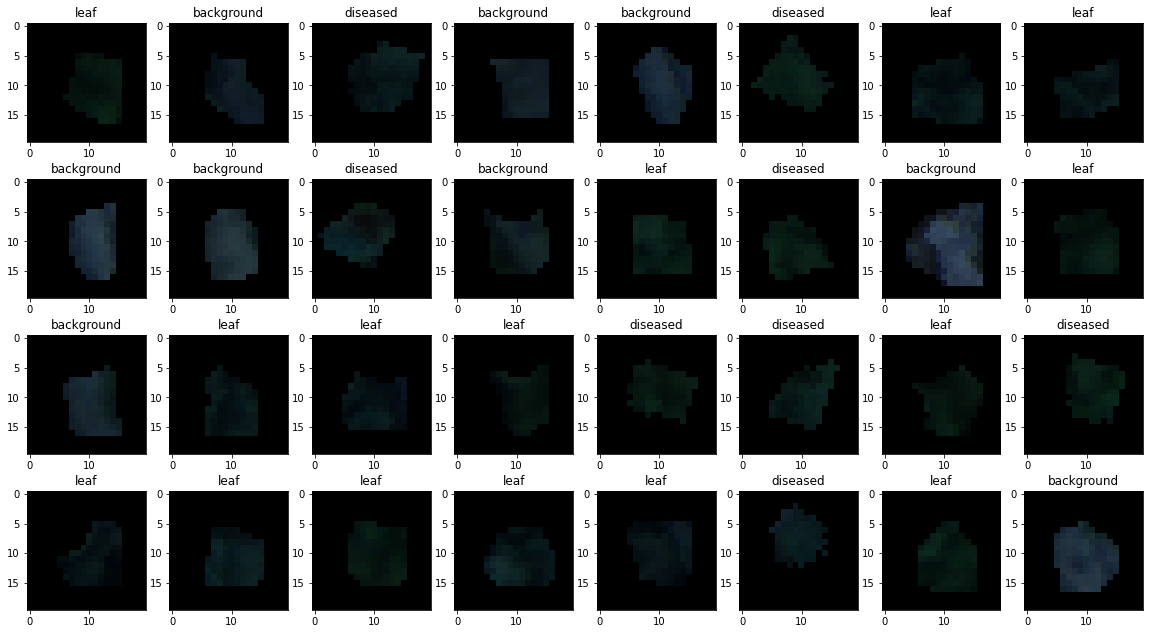

In [15]:
# Check the images

for train_sample in train_loader:
   displayImgs(train_sample[0], train_sample[1], classes=classes, n=batch_size)
   break

In [ ]:
# Check the model

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)
        print(x_[0])
        break

tensor([ 0.8068, -0.1991,  0.1152], device='cuda:0')


In [ ]:
# Evaluate the model

def evaluate(loader, model):
    actuals = np.array([])
    predictions = np.array([])
    evaluations = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, model_pred = scores.max(1)
            actuals = np.append(actuals, y.cpu().detach().numpy())
            predictions = np.append(predictions, model_pred.cpu().detach().numpy())
    
    for i in range(num_classes):
        ac = (actuals == i)
        pr = (predictions == i)

        ca = (ac & pr).sum() / ac.sum()
        evaluations = np.append(evaluations, ca)
        
    oa = (actuals == predictions).sum() / len(actuals)
    evaluations = np.append(evaluations, oa)
    
    model.train()

    return evaluations

print(evaluate(train_loader, model), evaluate(test_loader, model))

[0.         0.         1.         0.38804071] [0.         0.         1.         0.38575668]


In [ ]:
# Make a list to record training progress

eval_ent = [test_loader, train_loader, loaders[2]]
eval_hist = [[[] for i in range(2 + num_classes)]for i in range(len(eval_ent))]
highest_acc = 0

In [ ]:
# Train the network

for epoch in range(num_epochs):
    batch_loss = np.array([])
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        predictions = torch.argmax(scores, dim=1)
               
        loop.set_description(f"Epoch[{epoch}/{num_epochs - 1}]")
        
        batch_loss = np.append(batch_loss, loss.item())
    
    scheduler.step()
    eval_hist[0][0].append(np.average(batch_loss))
    
    for ee, eh in zip(eval_ent, eval_hist):
        ev = evaluate(ee, model)
        for i in range(len(ev)):
            eh[i + 1].append(ev[i])
        
    if eval_hist[2][-1][-1] > highest_acc:
        print(f"Best is on {epoch} epoch") 
        torch.save(model.state_dict(), os.getcwd() + f"\\ResNet3D_노균병_best.pt")
        highest_acc = eval_hist[2][-1][-1]
        
    print(optimizer.param_groups[0]['lr'])   
    for i in range(num_classes + 1):
        print(f"accuracy_{i}: {eval_hist[0][i + 1][-1]}, {eval_hist[1][i + 1][-1]}, {eval_hist[2][i + 1][-1]}")

Epoch[0/49]: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:23<00:00,  3.38s/it]


Best is on 0 epoch
1e-06
accuracy_0: 0.0, 0.0, 0.0
accuracy_1: 0.0, 0.0, 0.0
accuracy_2: 1.0, 1.0, 1.0
accuracy_3: 0.3857566765578635, 0.3880407124681934, 0.11158798283261803


Epoch[1/49]: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.48s/it]


Best is on 1 epoch
1e-06
accuracy_0: 0.948051948051948, 0.9608938547486033, 0.948051948051948
accuracy_1: 0.0, 0.0, 0.0
accuracy_2: 0.0, 0.003278688524590164, 0.0
accuracy_3: 0.2166172106824926, 0.22010178117048346, 0.3133047210300429


Epoch[2/49]: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.54s/it]


Best is on 2 epoch
1e-06
accuracy_0: 1.0, 1.0, 1.0
accuracy_1: 0.0, 0.0, 0.0
accuracy_2: 0.0, 0.0, 0.0
accuracy_3: 0.228486646884273, 0.227735368956743, 0.33047210300429186


Epoch[3/49]: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.76s/it]


1e-06
accuracy_0: 1.0, 1.0, 1.0
accuracy_1: 0.0, 0.0, 0.0
accuracy_2: 0.0, 0.0, 0.0
accuracy_3: 0.228486646884273, 0.227735368956743, 0.33047210300429186


Epoch[4/49]: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.52s/it]


1e-06
accuracy_0: 1.0, 1.0, 1.0
accuracy_1: 0.0, 0.0, 0.0
accuracy_2: 0.0, 0.01639344262295082, 0.0
accuracy_3: 0.228486646884273, 0.2340966921119593, 0.33047210300429186


Epoch[5/49]: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.43s/it]


Best is on 5 epoch
1e-06
accuracy_0: 0.987012987012987, 0.9888268156424581, 0.987012987012987
accuracy_1: 0.2153846153846154, 0.19205298013245034, 0.2153846153846154
accuracy_2: 0.47692307692307695, 0.5278688524590164, 0.23076923076923078
accuracy_3: 0.49258160237388726, 0.5038167938931297, 0.4721030042918455


Epoch[6/49]: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.42s/it]


Best is on 6 epoch
1e-06
accuracy_0: 0.961038961038961, 0.9720670391061452, 0.961038961038961
accuracy_1: 0.676923076923077, 0.7384105960264901, 0.676923076923077
accuracy_2: 0.7307692307692307, 0.7868852459016393, 0.23076923076923078
accuracy_3: 0.7626112759643917, 0.8104325699745547, 0.721030042918455


Epoch[7/49]: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.36s/it]


Best is on 7 epoch
1e-06
accuracy_0: 0.961038961038961, 0.9608938547486033, 0.961038961038961
accuracy_1: 0.823076923076923, 0.8675496688741722, 0.823076923076923
accuracy_2: 0.8461538461538461, 0.8721311475409836, 0.38461538461538464
accuracy_3: 0.8635014836795252, 0.8905852417302799, 0.8197424892703863


Epoch[8/49]: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:15<00:00,  2.22s/it]


1e-06
accuracy_0: 0.922077922077922, 0.9329608938547486, 0.922077922077922
accuracy_1: 0.7923076923076923, 0.8013245033112583, 0.7923076923076923
accuracy_2: 0.9230769230769231, 0.9180327868852459, 0.6153846153846154
accuracy_3: 0.8724035608308606, 0.8765903307888041, 0.8154506437768241


Epoch[9/49]: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.07s/it]


1e-06
accuracy_0: 0.922077922077922, 0.9273743016759777, 0.922077922077922
accuracy_1: 0.7153846153846154, 0.7483443708609272, 0.7153846153846154
accuracy_2: 0.9307692307692308, 0.9475409836065574, 0.6538461538461539
accuracy_3: 0.8456973293768546, 0.8664122137404581, 0.776824034334764


Epoch[10/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.12s/it]


1e-06
accuracy_0: 0.922077922077922, 0.9273743016759777, 0.922077922077922
accuracy_1: 0.7076923076923077, 0.7516556291390728, 0.7076923076923077
accuracy_2: 0.9384615384615385, 0.9508196721311475, 0.6923076923076923
accuracy_3: 0.8456973293768546, 0.8689567430025446, 0.776824034334764


Epoch[11/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.95s/it]


1e-06
accuracy_0: 0.9090909090909091, 0.9106145251396648, 0.9090909090909091
accuracy_1: 0.7538461538461538, 0.7913907284768212, 0.7538461538461538
accuracy_2: 0.9307692307692308, 0.9475409836065574, 0.6538461538461539
accuracy_3: 0.857566765578635, 0.8791348600508906, 0.7939914163090128


Epoch[12/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.97s/it]


1e-06
accuracy_0: 0.8961038961038961, 0.9106145251396648, 0.8961038961038961
accuracy_1: 0.7538461538461538, 0.8178807947019867, 0.7538461538461538
accuracy_2: 0.9307692307692308, 0.9442622950819672, 0.6538461538461539
accuracy_3: 0.8545994065281899, 0.8880407124681934, 0.7896995708154506


Epoch[13/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.93s/it]


Best is on 13 epoch
1e-06
accuracy_0: 0.922077922077922, 0.9162011173184358, 0.922077922077922
accuracy_1: 0.8153846153846154, 0.8841059602649006, 0.8153846153846154
accuracy_2: 0.9153846153846154, 0.9344262295081968, 0.5769230769230769
accuracy_3: 0.8783382789317508, 0.910941475826972, 0.8240343347639485


Epoch[14/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.93s/it]


1e-06
accuracy_0: 0.922077922077922, 0.9329608938547486, 0.922077922077922
accuracy_1: 0.8076923076923077, 0.8874172185430463, 0.8076923076923077
accuracy_2: 0.9153846153846154, 0.9344262295081968, 0.5769230769230769
accuracy_3: 0.8753709198813057, 0.916030534351145, 0.8197424892703863


Epoch[15/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.94s/it]


1e-06
accuracy_0: 0.922077922077922, 0.9385474860335196, 0.922077922077922
accuracy_1: 0.8, 0.8642384105960265, 0.8
accuracy_2: 0.9153846153846154, 0.9442622950819672, 0.5769230769230769
accuracy_3: 0.8724035608308606, 0.9122137404580153, 0.8154506437768241


Epoch[16/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.92s/it]


1e-06
accuracy_0: 0.922077922077922, 0.9385474860335196, 0.922077922077922
accuracy_1: 0.7461538461538462, 0.8211920529801324, 0.7461538461538462
accuracy_2: 0.9384615384615385, 0.9606557377049181, 0.6923076923076923
accuracy_3: 0.8605341246290801, 0.9020356234096693, 0.7982832618025751


Epoch[17/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.96s/it]


1e-06
accuracy_0: 0.922077922077922, 0.9385474860335196, 0.922077922077922
accuracy_1: 0.8153846153846154, 0.9072847682119205, 0.8153846153846154
accuracy_2: 0.9076923076923077, 0.9475409836065574, 0.5384615384615384
accuracy_3: 0.8753709198813057, 0.9300254452926209, 0.8197424892703863


Epoch[18/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  2.00s/it]


Best is on 18 epoch
1e-06
accuracy_0: 0.922077922077922, 0.9553072625698324, 0.922077922077922
accuracy_1: 0.8769230769230769, 0.9403973509933775, 0.8769230769230769
accuracy_2: 0.8923076923076924, 0.9344262295081968, 0.46153846153846156
accuracy_3: 0.8931750741839762, 0.9414758269720102, 0.8454935622317596


Epoch[19/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.99s/it]


1e-06
accuracy_0: 0.935064935064935, 0.9664804469273743, 0.935064935064935
accuracy_1: 0.8538461538461538, 0.9337748344370861, 0.8538461538461538
accuracy_2: 0.8923076923076924, 0.9377049180327869, 0.46153846153846156
accuracy_3: 0.887240356083086, 0.9427480916030534, 0.8369098712446352


Epoch[20/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.95s/it]


1e-06
accuracy_0: 0.935064935064935, 0.9608938547486033, 0.935064935064935
accuracy_1: 0.8307692307692308, 0.9172185430463576, 0.8307692307692308
accuracy_2: 0.9, 0.9508196721311475, 0.5
accuracy_3: 0.8813056379821959, 0.9402035623409669, 0.8283261802575107


Epoch[21/49]: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.92s/it]


1e-06
accuracy_0: 0.935064935064935, 0.9720670391061452, 0.935064935064935
accuracy_1: 0.8153846153846154, 0.9271523178807947, 0.8153846153846154
accuracy_2: 0.9, 0.9508196721311475, 0.5
accuracy_3: 0.8753709198813057, 0.9465648854961832, 0.8197424892703863


  0%|                                                                                            | 0/7 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Draw training graph

def smooth(y, box_pts=50):
    y = [y[0] for i in range(box_pts)] + y + [y[-1] for i in range(box_pts)]
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts: -box_pts]

eval_hist_s = []

for data in eval_hist:
    data_c = copy.deepcopy(data)
    for i in range(len(data_c)):
        if len(data_c[i]) > 0: 
            data_c[i] = smooth(data_c[i])
        
    eval_hist_s.append(data_c)

epochs = [e for e in range(num_epochs)]

plt.figure(figsize=(5, 10))
for i in range(num_classes):
    ax = plt.subplot(311 + i)
    ax.set_title(classes[i])
    ax.plot(epochs, eval_hist_s[1][1 + i], 'blue', label='train smooth')
    ax.plot(epochs, eval_hist[1][1 + i], 'steelblue', linestyle='dashed', label='train')
    
    ax.plot(epochs, eval_hist_s[2][1 + i], 'red', label='test smooth')
    ax.plot(epochs, eval_hist[2][1 + i], 'lightcoral', linestyle='dashed', label='test')
    
    ax.legend(loc='lower right')

    
plt.figure(figsize=(5, 3))    
plt.plot(epochs, eval_hist_s[1][1 + num_classes], label='train smooth')
plt.plot(epochs, eval_hist[1][1 + num_classes], linestyle='dashed', label='train')   
plt.ylim(0, 2)
plt.title("loss")

In [ ]:
# save last
torch.save(model.state_dict(), os.getcwd() + "\\ResNet3D_노균병_last_ep.pt")

# Load weights
model.load_state_dict(torch.load(os.getcwd() + "\\ResNet3D_노균병_best.pt"))

In [ ]:
# Predict 

def predictDataset(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
    
    return actual, prediction

In [ ]:
predictions = []
for dataset in loaders:
    predictions.append(predictDataset(dataset, model))

In [ ]:
def drawConfusionMatrix(actual, prediction, normalize=True, savefig=False):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    if normalize:
        confusion_matrix = cmn
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2"])
    cm_display.plot()
    plt.show()
    
    if savefig:
        plt.savefig('confusion_matrix.png')

In [ ]:
for actual, prediction in predictions:
    drawConfusionMatrix(actual, prediction, normalize=True)